# Building flat field frames

The flat field takes into account the multiplicative pixel-to-pixel variations of the system's response, including the gain of the camera and the [vignetting](https://en.wikipedia.org/wiki/Vignetting). The flat field is typically normalized to its mean value as a dimensionless quantity. The absolute value of the optics efficiency and of the gain of the sensor being determined independently (by [PTC analysis](ptc.ipynb) for the gain)

A flat-field image is obtained y illuminating the sensor with a uniform light source. This can be achieved using the sky background at dawn or dusk (so that there are no stars), or a flat panel (which we will use). A single flat-field image is a light image and must therefore be dark-subtracted before use. Given the very short exposures used for flat-fields, we will use the 0-second dark created in the [dark frame notebook](darks.ipynb).

One should not use a single flat-field frame to calibrate a light frame, for otherwise the random fluctuations of the signal and read noise would be added to the result. One must thus estimate the *mean* flat field from a large number of acquisitions made at the detector settings chosen for the light images.

## Data acquisition

We will operate at gain setting 100, as justified by analyzing the [noise in a stack of images](exposure.ipynb). For gain 100, we determined that the [optimal bias](bias.ipynb) is 15.

For each one of the seven filters (L, R, G, B, SII, H&#0945;, OIII), adjust the brightness of the panel and the exposure time to be close to saturation without reaching it. Then take 100 images at gain 100 and bias 15, and store them in seven different directories.

## Data reduction

For each filter, we read in the files, and compute the average. We display the image and its histogram next to it.

100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


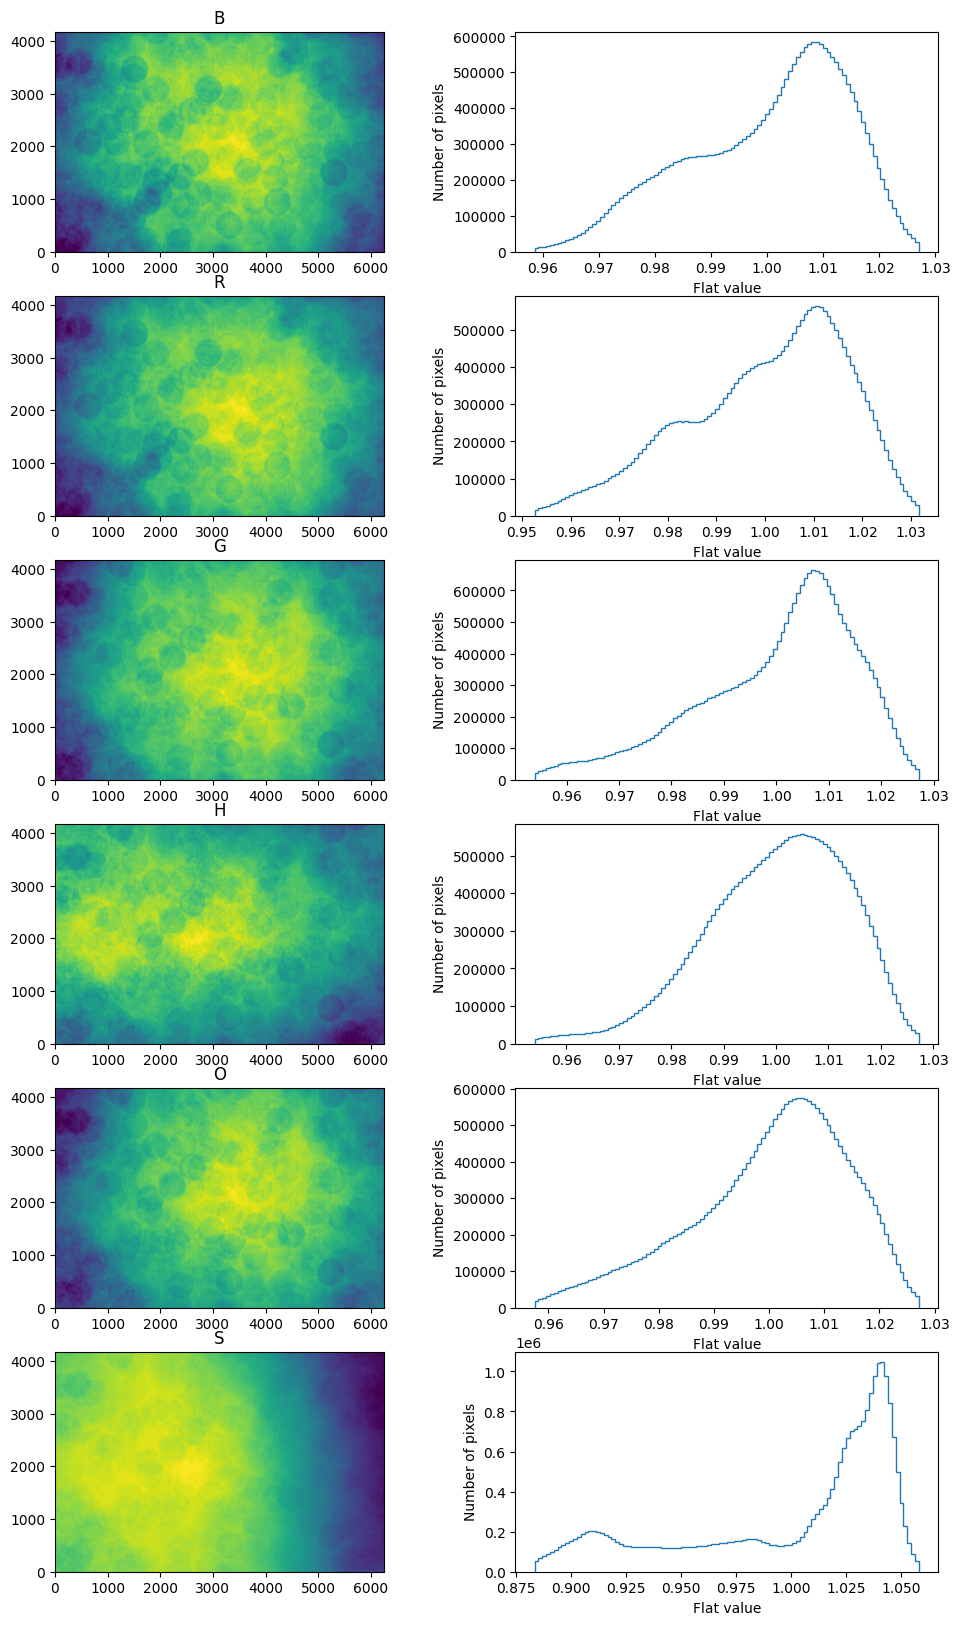

In [1]:
import os
import inout
from tqdm import tqdm
import numpy as np
import glob
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, PercentileInterval
import matplotlib.pyplot as plt

# Replace by your directory
paths = [r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-23\Flat\100\B',
         r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-23\Flat\100\R',
         r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-24\Flat\100\G',
         r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-24\Flat\100\H',
         r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-24\Flat\100\O',
         r'C:\Users\fauchere\Pictures\ASI2600MM\2023-07-24\Flat\100\S',]

dark = fits.getdata(r"C:\EOS6D\bias\asi2600mm_dark_iso00100_t-5.400_00.0s_2023-07-15.fits")

fix, axes = plt.subplots(len(paths), 2, figsize=(12, 20))

flat_frames = []  # used to save the stacked flat frames
base_headers = []  # used to save one header for later
for i, path in enumerate(paths):
        files = glob.glob(os.path.join(path, '*.fits'))

        # Averages the flat frames
        flat_frame = 0
        for f in tqdm(files):
            flat_frame = flat_frame + np.float32(fits.getdata(f)) - dark
        flat_frame = flat_frame / len(files)
        # Normalize to the mean
        flat_frame /= np.mean(flat_frame)

        flat_frames.append(flat_frame)
        base_header = fits.getheader(files[0])
        base_headers.append(base_header)

        norm = ImageNormalize(flat_frame, stretch=LinearStretch(), interval=PercentileInterval(99.5))

        axes[i, 0].imshow(flat_frame, norm=norm, origin='lower')
        axes[i, 0].set_title(base_header['FILTER'])
        axes[i, 1].hist(flat_frame.flatten(), histtype='step', bins=100, range=[norm.vmin, norm.vmax])
        axes[i, 1].set_xlabel('Flat value')
        axes[i, 1].set_ylabel('Number of pixels')

In [3]:
camera = 'ASI2600MM'
telescope = 'esprit100ED'

for base_header, flat_frame in zip(base_headers, flat_frames):

        gain = base_header['GAIN']
        date = base_header['DATE-OBS']
        temp = base_header['CCD-TEMP']
        filt = base_header['FILTER']

        keys = (
                ('DATE-OBS', date),
                ('TELESCOP', telescope),
                ('INSTRUME', camera),
                ('OFFSET', base_header['OFFSET']),
                ('ISO', gain),
                ('EXPTIME', base_header['EXPTIME']),
                ('NBIMGS', int(len(files))),
                ('TEMP', temp),
                ('FNUMBER', '5.5'),
                ('FILTER', filt)
        )

        # change to whatever directory you want ot store the stacked flats into
        inout.save_calibration_frame(rf'C:\EOS6D\vignetting\flat_{telescope}_iso00{gain}_{filt}_t{temp:.3f}_{date[0:10]}.fits', flat_frame, keys)